In [2]:
from d2l import torch as d2l
import torch
import os

## 9.5 Machine Translation and the Dataset

In [3]:
#@save
d2l.DATA_HUB['fra-eng'] = (d2l.DATA_URL + 'fra-eng.zip', '94646ad1522d915e7b0f9296181140edcf86a4f5')

#@save
def read_data_nmt():
    """Load the English-French dataset."""
    data_dir = d2l.download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r') as f:
        return f.read()

raw_text = read_data_nmt()
print(raw_text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



### Preprocessing the Dataset
- we replace non-breaking space with space, convert uppercase letters to lowercase ones, and insert space between words and punctuation marks.

In [4]:
def preprocess_nmt(text):
    """Preprocess the English-French dataset."""
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '

    # Replace non-breaking space with space, and convert uppercase letters to
    # lowercase ones
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # Insert space between words and punctuation marks
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text)]
    return ''.join(out)

text = preprocess_nmt(raw_text)
print(text[:80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


### Tokenization
- Word-level tokenization

In [5]:
#@save
def tokenize_nmt(text, num_examples=None):
    """Tokenize the English-French dataset."""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

source, target = tokenize_nmt(text)
source[:6], target[:6]

([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who', '?'],
  ['wow', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!']])

- EDA
   - In this simple English-French dataset, most of the text sequences have fewer than 20 tokens.

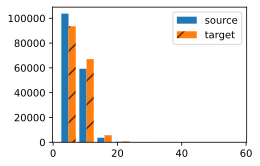

In [6]:
d2l.set_figsize()
_, _, patches = d2l.plt.hist(
    [[len(l) for l in source], [len(l) for l in target]],
    label=['source', 'target'])
for patch in patches[1].patches:
    patch.set_hatch('/')
d2l.plt.legend(loc='upper right');

### Vocabulary
- The vocabulary size will be significantly larger than that using character-level tokenization.
- To alleviate this, here we treat infrequent tokens that appear less than 2 times as the same unknown < unk > token.
- Besides that, we specify additional special tokens such as for padding < pad > sequences to the same length in minibatches, and for marking the beginning < bos > or end < eos > of sequences.
- Such special tokens are commonly used in natural language processing tasks.

In [7]:
src_vocab = d2l.Vocab(source, min_freq=2, reserved_tokens=['<pad>', '<bos>', '<eos>'])
len(src_vocab)

10012

## truncation and padding
num_steps
- If a text sequence has fewer than num_steps tokens, we will keep appending the special < pad > token to its end until its length reaches num_steps.
- Otherwise, we will truncate the text sequence by only taking its first num_steps tokens and discarding the remaining.
- In this way, every text sequence will have the same length to be loaded in minibatches of the same shape.

In [14]:
def truncate_pad(line, num_steps, padding_token):
    """Truncate or pad sequences."""
    if len(line) > num_steps:
        return line[:num_steps]  # Truncate
    return line + [padding_token] * (num_steps - len(line))  # Pad

def build_array_nmt(lines, vocab, num_steps):
    """Transform text sequences of machine translation into minibatches."""
    lines = [vocab[l] for l in lines]
    
    # append the special <eos> to the end of every sequence to indicate the end of the sequence
    lines = [l + [vocab['<eos>']] for l in lines]
    array = torch.tensor([truncate_pad(l, num_steps, vocab['<pad>']) for l in lines])
    
    # excluding the padding tokens for text length calculation
    valid_len = d2l.reduce_sum(d2l.astype(array != vocab['<pad>'], torch.int32), 1)
    return array, valid_len

truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

[47, 4, 1, 1, 1, 1, 1, 1, 1, 1]

In [13]:
print(src_vocab[source[0]])
print(source[0])
print(src_vocab['<pad>'])

[47, 4]
['go', '.']
1


### Putting All Things Together
Generate minibatch from the English-French dataset.

In [15]:
def load_data_nmt(batch_size, num_steps, num_examples=600):
    """Return the iterator and the vocabularies of the translation dataset."""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = d2l.Vocab(source, min_freq=2, reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=2, reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = d2l.load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

In [19]:
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print('X:', X.type(torch.int32))
    print('valid lengths for X:', X_valid_len)
    print('Y:', Y.type(torch.int32))
    print('valid lengths for Y:', Y_valid_len)
    break

X: tensor([[ 53,  94,  11,   3,   1,   1,   1,   1],
        [ 34, 164,   4,   3,   1,   1,   1,   1]], dtype=torch.int32)
valid lengths for X: tensor([4, 4])
Y: tensor([[ 26,  14, 197,   9,   3,   1,   1,   1],
        [  0,   5,   3,   1,   1,   1,   1,   1]], dtype=torch.int32)
valid lengths for Y: tensor([5, 3])
0


In [42]:
source[1], src_vocab[source[1]] + [src_vocab['<eos>']] + [src_vocab['<pad>']]

(['hi', '.'], [132, 4, 3, 1])

## 9.6 Encoder-Decoder Architecture

In [43]:
from torch import nn

#@save
class Encoder(nn.Module):
    """The base encoder interface for the encoder-decoder architecture."""
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)

    def forward(self, X, *args):
        raise NotImplementedError

In [44]:
class Decoder(nn.Module):
    """The base decoder interface for the encoder-decoder architecture."""
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)

    def init_state(self, enc_outputs, *args):
        raise NotImplementedError

    def forward(self, X, state):
        raise NotImplementedError

In [45]:
class EncoderDecoder(nn.Module):
    """The base class for the encoder-decoder architecture."""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

## 9.7 Sequence to Sequence Learning

### encoder

In [53]:
class Seq2SeqEncoder(d2l.Encoder):
    """The RNN encoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers, dropout=dropout)

    def forward(self, X, *args):
        # The output `X` shape: (`batch_size`, `num_steps`, `embed_size`)
        X = self.embedding(X)
        # In RNN models, the first axis corresponds to time steps
        X = X.permute(1, 0, 2)
        # When state is not mentioned, it defaults to zeros
        output, state = self.rnn(X)
        # `output` shape: (`num_steps`, `batch_size`, `num_hiddens`)
        # `state` shape: (`num_layers`, `batch_size`, `num_hiddens`)
        return output, state

In [55]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=3)
encoder.eval()
X = torch.zeros((4, 20), dtype=torch.long) # batch = 4, seq = 7 (num_steps)
output, state = encoder(X)
output.shape, state.shape

(torch.Size([20, 4, 16]), torch.Size([3, 4, 16]))

### decoder

In [56]:
class Seq2SeqDecoder(d2l.Decoder):
    """The RNN decoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def forward(self, X, state):
        # The output `X` shape: (`num_steps`, `batch_size`, `embed_size`)
        X = self.embedding(X).permute(1, 0, 2)
        # Broadcast `context` so it has the same `num_steps` as `X`
        context = state[-1].repeat(X.shape[0], 1, 1)
        
        # the context variable is concatenated with the decoder input at all the time steps
        X_and_context = torch.cat((X, context), 2)
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).permute(1, 0, 2)
        # `output` shape: (`batch_size`, `num_steps`, `vocab_size`)
        # `state` shape: (`num_layers`, `batch_size`, `num_hiddens`)
        return output, state

In [58]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=3)
decoder.eval()
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)
output.shape, state.shape

(torch.Size([4, 20, 10]), torch.Size([3, 4, 16]))

### Loss Function
- Prediction of padding tokens should be excluded from loss calculations.
- Using sequence_mask function to mask irrelevant entries with zero values so later multiplication of any irrelevant prediction with zero equals to zero

In [60]:
# We can also mask all the entries across the last few axes
def sequence_mask(X, valid_len, value=0):
    """Mask irrelevant entries in sequences."""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

X = torch.tensor([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, torch.tensor([1, 2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

In [66]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """The softmax cross-entropy loss with masks."""
    # `pred` shape: (`batch_size`, `num_steps`, `vocab_size`)
    # `label` shape: (`batch_size`, `num_steps`)
    # `valid_len` shape: (`batch_size`,)
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction='none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

In [67]:
loss = MaskedSoftmaxCELoss()
loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long), torch.tensor([4, 2, 0]))

tensor([2.3026, 1.1513, 0.0000])

### Training

In [71]:
def train_s2s_ch9(model, data_iter, lr, num_epochs, tgt_vocab, device):
    """Train a model for sequence to sequence (defined in Chapter 9)."""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    torch.nn.init.xavier_uniform_(m._parameters[param])
                    
    model.apply(xavier_init_weights)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    model.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs])
    
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
        for batch in data_iter:
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0], device=device).reshape(-1, 1)
            
            # Teacher forcing
            # The original output sequence (token labels) is fed into the decoder excluding the final token of decoder
            dec_input = torch.cat([bos, Y[:, :-1]], 1)
            
            # Y_hat: predicted
            Y_hat, _ = model(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            
            # Make the loss scalar for `backward`
            l.sum().backward()  
            d2l.grad_clipping(model, 1)
            
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} 'f'tokens/sec on {str(device)}')

loss 0.021, 9232.8 tokens/sec on cuda:0


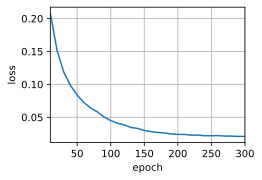

In [72]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = d2l.EncoderDecoder(encoder, decoder)
train_s2s_ch9(model, train_iter, lr, num_epochs, tgt_vocab, device)

In [74]:
def predict_s2s_ch9(model, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device):
    """Predict sequences (defined in Chapter 9)."""
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # Add the batch axis
    enc_X = torch.unsqueeze(torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = model.encoder(enc_X, enc_valid_len)
    dec_state = model.decoder.init_state(enc_outputs, enc_valid_len)
    # Add the batch axis
    dec_X = torch.unsqueeze(torch.tensor([tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq = []
    for _ in range(num_steps):
        Y, dec_state = model.decoder(dec_X, dec_state)
        # We use the token with the highest prediction likelihood as the input
        # of the decoder at the next time step
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # Once the end-of-sequence token is predicted, the generation of
        # the output sequence is complete
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq))

### Bleu score

In [75]:
def bleu(pred_seq, label_seq, k):  #@save
    """Compute the BLEU."""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[''.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[''.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[''.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [81]:
import math
import collections

def translate(engs, fras, model, src_vocab, tgt_vocab, num_steps, device):
    """Translate text sequences."""
    for eng, fra in zip(engs, fras):
        translation = predict_s2s_ch9(
            model, eng, src_vocab, tgt_vocab, num_steps, device)
        print(
            f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

engs = ['go .', "i lost .", 'i\'m home .', 'he\'s calm .']
fras = ['va !', 'j\'ai perdu .', 'je suis chez moi .', 'il est calme .']
translate(engs, fras, model, src_vocab, tgt_vocab, num_steps, device)

go . => va , maintenant ., bleu 0.000
i lost . => je le <unk> en nous ., bleu 0.000
i'm home . => je suis tom ., bleu 0.512
he's calm . => il est paresseux ., bleu 0.658
